In [1]:
import pandas as pd
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from time import time
from sklearn import metrics
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [3]:
from sklearn.cluster import KMeans, DBSCAN, OPTICS
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from scipy.spatial.distance import euclidean

In [4]:
dataset_root = Path('../../Dataset/ingested')

In [34]:
#df_file = sorted(list((dataset_root).glob('features*.csv')))[ 0 ]
#df_file = sorted(list((dataset_root).glob('fsfel_spectral_features*.csv')))[ 0 ]
#df_file = sorted(list((dataset_root).glob('fsfel_temporal_features*.csv')))[ 0 ]
#df_file = sorted(list((dataset_root).glob('fsfel_statistical_features*.csv')))[ 0 ]
df_file = sorted(list((dataset_root).glob('fsfel_all_features*.csv')))[ 0 ]
df_features = pd.read_csv( df_file, index_col = 'sample_name' )
print(df_file)

../../Dataset/ingested/fsfel_all_features_0.csv


In [35]:
df_features

,Absolute energy,Area under the curve,Autocorrelation,Centroid,ECDF Percentile Count_0,ECDF Percentile Count_1,ECDF Percentile_0,ECDF Percentile_1,ECDF_0,ECDF_1,...,Wavelet variance_0,Wavelet variance_1,Wavelet variance_2,Wavelet variance_3,Wavelet variance_4,Wavelet variance_5,Wavelet variance_6,Wavelet variance_7,Wavelet variance_8,Zero crossing rate
sample_name,,,,,,,,,,,,,,,,,,,,,
MAC000002-2012-10,143.028305,2.776200,143.028305,10.898703,299.0,1196.0,0.000,0.307,0.000669,0.001338,...,0.020536,0.041642,0.076114,0.118772,0.159664,0.187189,0.199345,0.203901,0.209303,5.0
MAC000002-2012-11,142.307686,3.448940,142.307686,6.714764,299.0,1196.0,0.103,0.289,0.000669,0.001338,...,0.030100,0.042896,0.057508,0.077917,0.095408,0.108746,0.120687,0.133895,0.149320,9.0
MAC000002-2012-12,151.318359,3.555400,151.318359,7.013707,299.0,1196.0,0.104,0.293,0.000669,0.001338,...,0.031424,0.050123,0.071109,0.094537,0.114834,0.131182,0.146861,0.164570,0.184545,6.0
MAC000002-2013-01,154.403864,3.598440,154.403864,7.811695,299.0,1196.0,0.109,0.278,0.000669,0.001338,...,0.031152,0.054426,0.069617,0.089890,0.116362,0.145060,0.173281,0.200144,0.225378,4.0
MAC000002-2013-02,238.548989,3.817305,238.548989,8.363299,299.0,1196.0,0.088,0.288,0.000669,0.001338,...,0.038880,0.085373,0.162035,0.242712,0.310418,0.366311,0.415521,0.460266,0.502049,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MAC000036-2012-07,10.944161,0.871740,10.944161,7.567055,299.0,1196.0,0.006,0.083,0.000669,0.001338,...,0.003644,0.004351,0.005060,0.006127,0.007809,0.009306,0.009966,0.010026,0.010048,341.0
MAC000036-2012-08,12.477560,0.940690,12.477560,7.373486,299.0,1196.0,0.011,0.089,0.000669,0.001338,...,0.004342,0.004727,0.005289,0.005549,0.006693,0.008213,0.009467,0.010532,0.011682,307.0
MAC000036-2012-09,9.686995,0.822190,9.686995,6.869148,299.0,1196.0,0.005,0.080,0.000669,0.001338,...,0.003299,0.003054,0.003673,0.004611,0.006145,0.007606,0.008509,0.009030,0.009530,282.0


# DBSCAN cluster visualization

## First transform in 2D than cluster with DBSCAN


In [36]:
def visualize_clusters_dbscan( reduced_data, eps=0.3, min_samples=10, reduction_name = '' ):

    X = reduced_data
    
    db = DBSCAN(eps=eps, min_samples=min_samples, 
                metric='euclidean', metric_params=None, 
                algorithm='auto', leaf_size=30, p=None).fit(X)
    
    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True
    labels = db.labels_

    # Number of clusters in labels, ignoring noise if present.
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)

    print("Estimated number of clusters: %d" % n_clusters_)
    print("Estimated number of noise points: %d" % n_noise_)
    print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(X, labels))

    # #############################################################################
    # Plot result

    # Black removed and is used for noise instead.
    unique_labels = set(labels)
    colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

    plt.figure( figsize = (14,8) )
    for k, col in zip(unique_labels, colors):

        if k == -1:
            # Black used for noise.
            col = [0, 0, 0, 1]

        class_member_mask = labels == k

        xy = X[class_member_mask & core_samples_mask]
        plt.plot(
            xy[:, 0],
            xy[:, 1],
            "o",
            markerfacecolor=tuple(col),
            markeredgecolor="k",
            markersize=14,
        )

        xy = X[class_member_mask & ~core_samples_mask]
        plt.plot(
            xy[:, 0],
            xy[:, 1],
            "o",
            markerfacecolor=tuple(col),
            markeredgecolor="k",
            markersize=6,
        )

    plt.title(f"Reduction: {reduction_name} Estimated number of clusters: {n_clusters_}")
    plt.show()

In [37]:
data = df_features.values

Estimated number of clusters: 13
Estimated number of noise points: 42
Silhouette Coefficient: 0.354


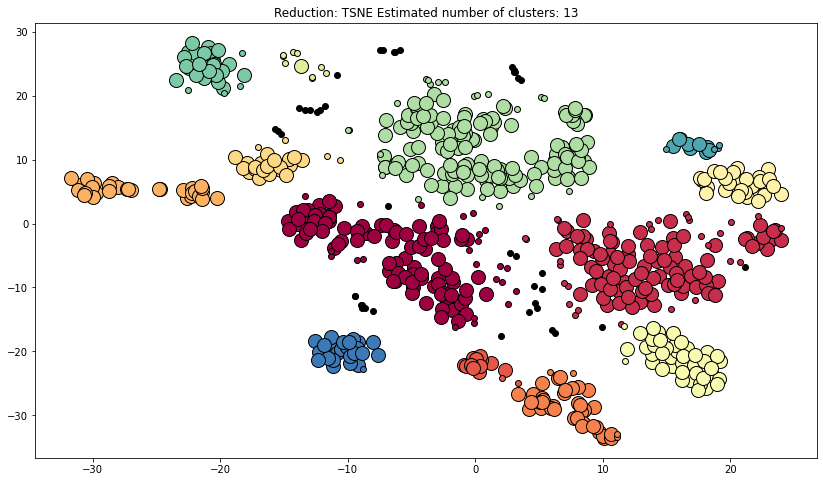

In [38]:
reduced_data = make_pipeline(StandardScaler(), TSNE(n_components=2)).fit_transform(data).astype( np.float64 )
visualize_clusters_dbscan( reduced_data, reduction_name = 'TSNE', eps = 3 )

In [39]:
df_features.describe().T

,count,mean,std,min,25%,50%,75%,max
Absolute energy,698.0,298.536723,723.013141,0.042696,36.559094,93.883068,265.913230,7320.472368
Area under the curve,698.0,3.430223,2.752350,0.047440,1.611885,2.682017,4.652719,17.221635
Autocorrelation,698.0,298.536723,723.013141,0.042696,36.559094,93.883068,265.913230,7320.472368
Centroid,698.0,7.374709,1.336470,1.803037,6.757398,7.379266,7.879010,14.617021
ECDF Percentile Count_0,698.0,298.571633,11.317317,0.000000,299.000000,299.000000,299.000000,299.000000
...,...,...,...,...,...,...,...,...
Wavelet variance_5,698.0,0.562049,2.132396,0.000027,0.029114,0.082628,0.273146,23.601140
Wavelet variance_6,698.0,0.677000,2.605548,0.000030,0.033192,0.097852,0.324091,28.823048
Wavelet variance_7,698.0,0.789690,3.077148,0.000034,0.037228,0.114280,0.369413,34.029862
Wavelet variance_8,698.0,0.907956,3.581315,0.000038,0.040444,0.129574,0.388305,39.595663


In [40]:
from collections import namedtuple

class Results(namedtuple('Results',['algo','param','n_clusters','n_outliers',
                                    'ratio_outliers','score'])):
    def __str__(self):
        return(f'algo={self.algo:6s}, '+
               f'param={self.param:4.3f}, '+
               f'n_clusters={self.n_clusters:4d}, '+
               f'n_outliers={self.n_outliers:5d}, '+
               f'ratio_outliers={self.ratio_outliers:0.3f}, '+
               f'score={self.score:0.3f}')

class PipeResults(namedtuple('PipeResults',['pca','tsne','result'])):
    def __str__(self):
        return((f'pca={self.pca:4d}, ' if not self.pca is None else 'pca=None, ') +
               (f'tsne={self.tsne:4d}, ' if not self.tsne is None else 'tsne=None, ') +
                f'{self.result}')
    

In [41]:
def scale_data( X, pca, tsne ):
    scaled_data =   StandardScaler().fit_transform(X)
    if not pca is None :
        np.random.seed(100)
        scaled_data = PCA( n_components = pca ).fit_transform(scaled_data)
    if not tsne is None :
        np.random.seed(100)
        scaled_data = TSNE( n_components = tsne ).fit_transform(scaled_data)
    scaled_data = scaled_data.astype( np.float64 )
    return scaled_data

def dbascan_bench_and_labels( X, eps ):
    np.random.seed(100)
    db = DBSCAN( eps= eps, 
                 min_samples = 10, 
                 metric='euclidean', 
                 metric_params=None, 
                 algorithm='auto', 
                 leaf_size=30, p=None ).fit(X)  
    
    labels = db.labels_
    n_clusters = len(set(labels)) - (1 if -1 in db.labels_ else 0)
    n_outliers = list(labels).count(-1)
    if n_clusters > 1 :
        score = metrics.silhouette_score(X, labels)
    else :
        score = np.nan
        
    return Results( algo = 'DBSCAN', 
                    param = eps,
                    n_clusters = n_clusters,
                    n_outliers = n_outliers,
                    ratio_outliers = n_outliers / len(X),
                    score = score ),labels

In [42]:
import warnings
warnings.filterwarnings('ignore')

In [43]:
from tqdm import tqdm

In [44]:
df_features

,Absolute energy,Area under the curve,Autocorrelation,Centroid,ECDF Percentile Count_0,ECDF Percentile Count_1,ECDF Percentile_0,ECDF Percentile_1,ECDF_0,ECDF_1,...,Wavelet variance_0,Wavelet variance_1,Wavelet variance_2,Wavelet variance_3,Wavelet variance_4,Wavelet variance_5,Wavelet variance_6,Wavelet variance_7,Wavelet variance_8,Zero crossing rate
sample_name,,,,,,,,,,,,,,,,,,,,,
MAC000002-2012-10,143.028305,2.776200,143.028305,10.898703,299.0,1196.0,0.000,0.307,0.000669,0.001338,...,0.020536,0.041642,0.076114,0.118772,0.159664,0.187189,0.199345,0.203901,0.209303,5.0
MAC000002-2012-11,142.307686,3.448940,142.307686,6.714764,299.0,1196.0,0.103,0.289,0.000669,0.001338,...,0.030100,0.042896,0.057508,0.077917,0.095408,0.108746,0.120687,0.133895,0.149320,9.0
MAC000002-2012-12,151.318359,3.555400,151.318359,7.013707,299.0,1196.0,0.104,0.293,0.000669,0.001338,...,0.031424,0.050123,0.071109,0.094537,0.114834,0.131182,0.146861,0.164570,0.184545,6.0
MAC000002-2013-01,154.403864,3.598440,154.403864,7.811695,299.0,1196.0,0.109,0.278,0.000669,0.001338,...,0.031152,0.054426,0.069617,0.089890,0.116362,0.145060,0.173281,0.200144,0.225378,4.0
MAC000002-2013-02,238.548989,3.817305,238.548989,8.363299,299.0,1196.0,0.088,0.288,0.000669,0.001338,...,0.038880,0.085373,0.162035,0.242712,0.310418,0.366311,0.415521,0.460266,0.502049,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MAC000036-2012-07,10.944161,0.871740,10.944161,7.567055,299.0,1196.0,0.006,0.083,0.000669,0.001338,...,0.003644,0.004351,0.005060,0.006127,0.007809,0.009306,0.009966,0.010026,0.010048,341.0
MAC000036-2012-08,12.477560,0.940690,12.477560,7.373486,299.0,1196.0,0.011,0.089,0.000669,0.001338,...,0.004342,0.004727,0.005289,0.005549,0.006693,0.008213,0.009467,0.010532,0.011682,307.0
MAC000036-2012-09,9.686995,0.822190,9.686995,6.869148,299.0,1196.0,0.005,0.080,0.000669,0.001338,...,0.003299,0.003054,0.003673,0.004611,0.006145,0.007606,0.008509,0.009030,0.009530,282.0


In [45]:
def eps_search_space( scaled_data, steps = 100 ):
    distances = pd.DataFrame([[euclidean(scaled_data[i],scaled_data[j]) for i in range(j,scaled_data.shape[0])] for j in range(scaled_data.shape[0])])
    max_distance = distances.max().max()
    eps_min, eps_max  = max_distance * 0.01, max_distance * 0.9
    print( f'scaled_data.shape : {scaled_data.shape}')
    print( f'max_distance : {max_distance}')
    print( f'search_space : {eps_min},{eps_max},')
    return np.linspace( eps_min, eps_max, steps )


In [47]:
%%time
results_list = []
labels_list = []
for pca in tqdm([ None, 5, 10, 20, 30 ]) :    
    if (pca is None) or (pca < df_features.shape[1]):
        for tsne in [ None, 2 ] :

            scaled_data = scale_data( df_features, pca, tsne )

            for eps in eps_search_space( scaled_data ) :
                clustering_benchmark, labels = dbascan_bench_and_labels( scaled_data, eps )
                results_list.append( { 'pca' : pca,'tsne' : tsne, **clustering_benchmark._asdict() } )
                labels_list.append( labels )

  0%|          | 0/5 [00:00<?, ?it/s]

scaled_data.shape : (698, 390)
max_distance : 111.08886031097376
search_space : 1.1108886031097376,99.97997427987639,
scaled_data.shape : (698, 2)
max_distance : 73.01746439934925
search_space : 0.7301746439934925,65.71571795941433,


 20%|██        | 1/5 [00:04<00:18,  4.59s/it]

scaled_data.shape : (698, 5)
max_distance : 101.38476798311774
search_space : 1.0138476798311775,91.24629118480597,
scaled_data.shape : (698, 2)
max_distance : 83.59635635658005
search_space : 0.8359635635658005,75.23672072092204,


 40%|████      | 2/5 [00:08<00:12,  4.17s/it]

scaled_data.shape : (698, 10)
max_distance : 103.98854675895177
search_space : 1.0398854675895177,93.58969208305659,
scaled_data.shape : (698, 2)
max_distance : 74.49755743988034
search_space : 0.7449755743988034,67.0478016958923,


 60%|██████    | 3/5 [00:12<00:08,  4.11s/it]

scaled_data.shape : (698, 20)
max_distance : 110.78949337670697
search_space : 1.1078949337670698,99.71054403903628,
scaled_data.shape : (698, 2)
max_distance : 78.30993880057638
search_space : 0.7830993880057637,70.47894492051874,


 80%|████████  | 4/5 [00:16<00:04,  4.05s/it]

scaled_data.shape : (698, 30)
max_distance : 110.94397908344769
search_space : 1.1094397908344769,99.84958117510293,
scaled_data.shape : (698, 2)
max_distance : 79.58738297655913
search_space : 0.7958738297655913,71.62864467890321,


100%|██████████| 5/5 [00:20<00:00,  4.08s/it]

CPU times: user 38.4 s, sys: 7.71 s, total: 46.1 s
Wall time: 20.4 s


In [48]:
pd.DataFrame(results_list)

,pca,tsne,algo,param,n_clusters,n_outliers,ratio_outliers,score
0,NaN,NaN,DBSCAN,1.110889,0,698,1.000000,NaN
1,NaN,NaN,DBSCAN,2.109566,0,698,1.000000,NaN
2,NaN,NaN,DBSCAN,3.108244,1,682,0.977077,NaN
3,NaN,NaN,DBSCAN,4.106922,3,599,0.858166,-0.231153
4,NaN,NaN,DBSCAN,5.105599,3,486,0.696275,-0.147309
...,...,...,...,...,...,...,...,...
995,30.0,2.0,DBSCAN,68.766715,1,0,0.000000,NaN
996,30.0,2.0,DBSCAN,69.482197,1,0,0.000000,NaN
997,30.0,2.0,DBSCAN,70.197680,1,0,0.000000,NaN
998,30.0,2.0,DBSCAN,70.913162,1,0,0.000000,NaN


In [49]:
result_summary = (pd.DataFrame(results_list)
                  .assign( xref = lambda x : x.index )
                 .query( 'n_clusters > 1' )
                 .query( 'ratio_outliers < 0.1' )
                 .query( 'score > 0' )
                 .sort_values('score', ascending = False)
                 .groupby( 'n_clusters' )
                 .first()
                 .pipe( lambda x : x.set_index( zip( x.index, x.xref ) ) )
                )
result_summary

,,pca,tsne,algo,param,n_outliers,ratio_outliers,score,xref
2,206,5.0,2.0,DBSCAN,6.482481,52,0.074499,0.449210,206
3,306,5.0,2.0,DBSCAN,5.345100,0,0.000000,0.072961,306
4,905,30.0,2.0,DBSCAN,4.373286,5,0.007163,0.034493,905
5,105,20.0,2.0,DBSCAN,4.012273,19,0.027221,0.104368,105
7,704,20.0,2.0,DBSCAN,3.599093,12,0.017192,0.108658,704
9,504,10.0,2.0,DBSCAN,3.423878,3,0.004298,0.203571,504
10,303,5.0,2.0,DBSCAN,3.090532,15,0.021490,0.367371,303
11,104,NaN,2.0,DBSCAN,3.355853,26,0.037249,0.168882,104
12,503,10.0,2.0,DBSCAN,2.754152,34,0.048711,0.458699,503
14,703,20.0,2.0,DBSCAN,2.895095,36,0.051576,0.402597,703


<AxesSubplot:>

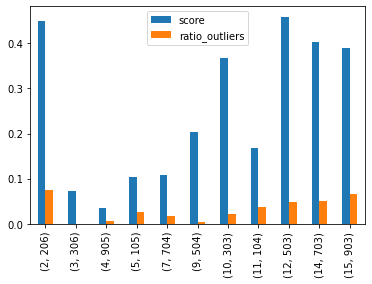

In [50]:
result_summary[['score','ratio_outliers']].plot(kind='bar')

In [51]:
show_xref = 303

In [52]:
( _ , pca, tsne, _ , eps , *_ ) = (result_summary
                                     .reset_index( level = 1 )
                                     .query( 'level_1 == @show_xref' )
                                     .iloc[0]
                                    )
pca = int(pca)
tsne = int(tsne)

5 2 3.090531962273565
Estimated number of clusters: 10
Estimated number of noise points: 15
Silhouette Coefficient: 0.367


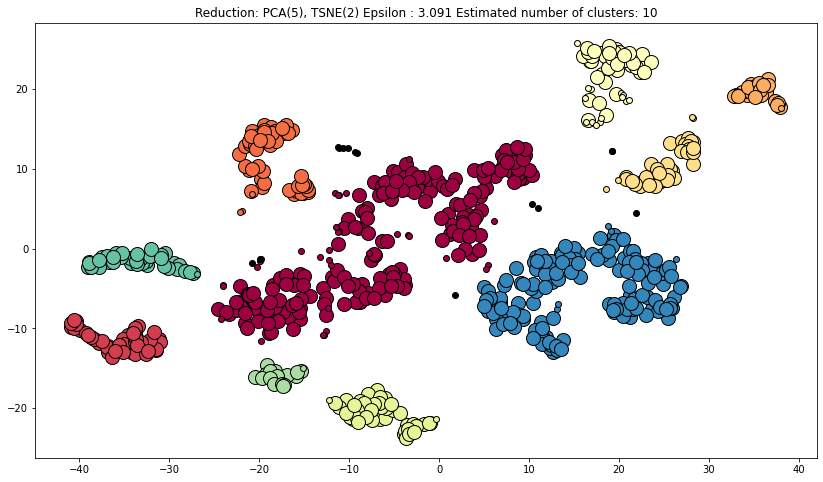

In [53]:
print(pca, tsne, eps)
scaled_data = scale_data( df_features, pca = pca, tsne = tsne )
visualize_clusters_dbscan( scaled_data, reduction_name = f'PCA({pca}), TSNE({tsne}) Epsilon : {eps:0.3f}', eps = eps )

In [29]:
df_series_file = sorted(list((dataset_root).glob('series*.csv')))[ 0 ]
print(f'Reading series from {df_series_file}')
df_series = pd.read_csv( df_series_file , index_col = 'sample_name' )
df_series.head()

Reading series from ../../Dataset/ingested/series_0.csv


,01-00:00:00,01-00:30:00,01-01:00:00,01-01:30:00,01-02:00:00,01-02:30:00,01-03:00:00,01-03:30:00,01-04:00:00,01-04:30:00,...,31-19:00:00,31-19:30:00,31-20:00:00,31-20:30:00,31-21:00:00,31-21:30:00,31-22:00:00,31-22:30:00,31-23:00:00,31-23:30:00
sample_name,,,,,,,,,,,,,,,,,,,,,
MAC000002-2012-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.346,0.291,0.333,0.368,0.951,1.445,0.946,0.305,0.243,0.252
MAC000002-2012-11,0.252,0.241,0.230,0.209,0.231,0.193,0.186,0.148,0.183,0.147,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MAC000002-2012-12,0.215,0.217,0.237,0.204,0.243,0.199,0.237,0.125,0.104,0.115,...,0.227,0.228,1.168,0.272,0.237,0.231,0.263,0.220,0.236,0.229
MAC000002-2013-01,0.219,0.241,0.191,0.235,0.182,0.229,0.194,0.201,0.122,0.099,...,0.194,0.214,1.078,0.227,0.250,0.240,0.281,0.248,0.266,0.257
MAC000002-2013-02,0.215,0.284,0.313,0.286,0.204,0.269,0.204,0.266,0.216,0.223,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [31]:
labels = labels_list[ show_xref ]
set(labels)

{0, 1, 2}

In [32]:
def show_cluster_sample( df_series, labels, num_samples_to_show, cluster, figsize = (14,6) ):
    name = f'#{cluster}' if cluster >= 0 else 'Outliers'
    ( df_series
      .assign( cluster = labels )
      .reset_index()
      .groupby(['cluster','sample_name'])
      .first()
      .loc[(cluster,)]
      .sample( num_samples_to_show, replace = False )  
      .T
    ).plot( figsize = (14,6), subplots = True, title = f'{num_samples_to_show} samples of Cluster {name}' )
    plt.show()


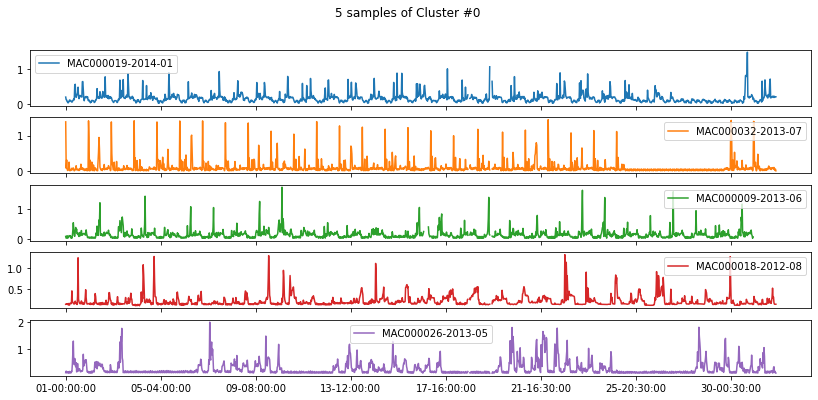

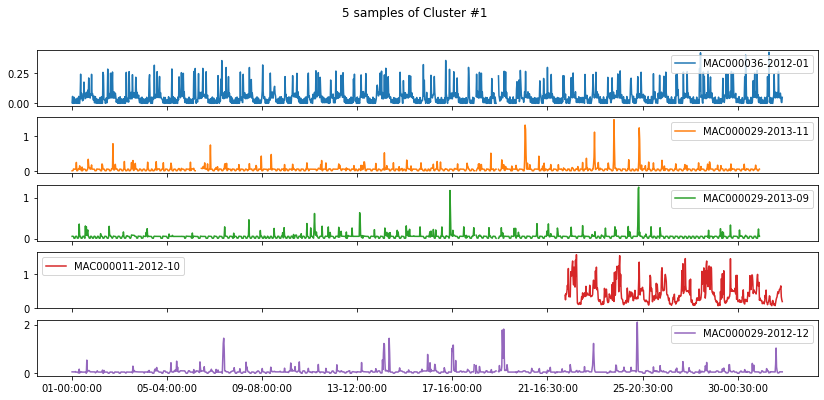

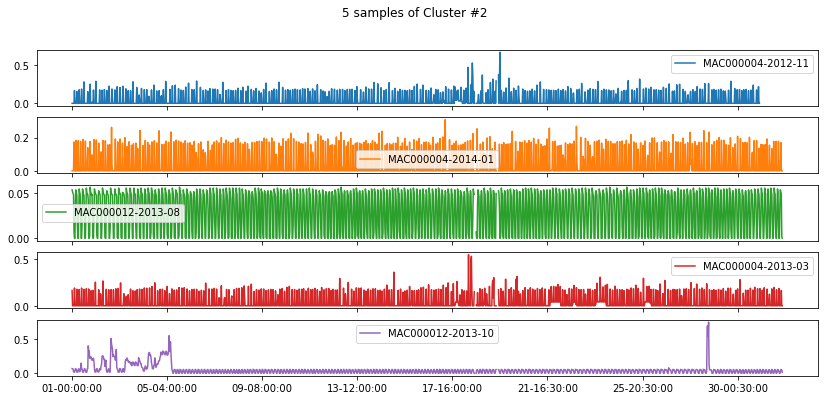

In [33]:
for c in set(labels):
    show_cluster_sample( df_series, labels, num_samples_to_show = 5, cluster = c )